## 1. Theory: OLS with Newey–West (HAC) standard errors

In the paper, the spillover index (or its log-return) is regressed on a set of exogenous variables (fuel prices, loads, RES shares, …) using OLS and Newey–West robust standard errors to correct for heteroskedasticity and autocorrelation:

$$
S_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_K x_{K,t} + \varepsilon_t,
$$

where

* ($S_t$) is the endogenous variable (e.g. total spillover, or “to others”, “from others”, etc.),
* ($x_{k,t}$) are exogenous regressors (here: CO₂/EUA, coal, TTF, …),
* ($\varepsilon_t$) is an error term that may be serially correlated and heteroskedastic.

OLS still gives unbiased/consistent point estimates under standard conditions, but the usual covariance estimator ($ \hat{\sigma}^2(X'X)^{-1}$) is wrong when errors are autocorrelated or heteroskedastic. Newey–West (HAC) replaces it with

$$
\widehat{\mathrm{Var}}*{\text{NW}}(\hat\beta)
= (X'X)^{-1} \left( \sum*{|\ell|\le L} w_\ell \Gamma_\ell \right) (X'X)^{-1},
$$

where

* ($\Gamma_\ell = \frac{1}{T} \sum_{t=\ell+1}^T u_t u_{t-\ell}' X_t' X_{t-\ell}$) are lag-($\ell$) autocovariances of residuals,
* ($w_\ell$) are Bartlett weights,
* ($L$) is the chosen truncation lag (“maxlags” in `statsmodels`).

In practice we:

1. Estimate OLS: ($\hat\beta = (X'X)^{-1}X'Y$).
2. Compute Newey–West robust covariance with chosen lag ($L$).
3. Use this covariance for t-stats, p-values and confidence intervals.

The code below implements exactly that via `statsmodels` (`cov_type="HAC"` and `cov_kwds={"maxlags": L}`), and runs *one regression per endogenous series*.





In [1]:
# %% 
# Imports and paths

from pathlib import Path
from typing import Dict, List, Optional

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Paths
OUT_DIR = Path("../data/endogenous/prices/differenced")
endog_path = OUT_DIR / "endogenous_tsi_diff.parquet"
exog_path = Path("../data/exogenous/all_exog_ready.parquet")


In [2]:
# %%
# Helper to load parquet and convert to wide format

def load_parquet_to_wide(
    path: Path,
    date_col: str = "date",
    series_col: str = "series",
    value_col: str = "value",
) -> pd.DataFrame:
    """
    Load a parquet file and return a wide DataFrame with a DatetimeIndex.

    If the file is in long format [date, series, value, ...], pivot to wide.
    If it's already wide with a 'date' column, just set 'date' as index.
    """
    df = pd.read_parquet(path)

    if {date_col, series_col, value_col}.issubset(df.columns):
        # Long format -> pivot to wide
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = (
            df.pivot(index=date_col, columns=series_col, values=value_col)
              .sort_index()
        )
    else:
        # Assume already wide with 'date' column
        if date_col not in df.columns:
            raise ValueError(
                f"'date' column not found in {path}. "
                "Add it or adapt `date_col` in load_parquet_to_wide()."
            )
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        df_wide = df.set_index(date_col).sort_index()

    df_wide.index = pd.to_datetime(df_wide.index)
    return df_wide


In [3]:
# %%
# Prepare regression data: align endogenous/exogenous and drop NAs

def prepare_regression_data(
    endog_path: Path,
    exog_path: Path,
    exog_cols: Optional[List[str]] = None,
) -> (pd.DataFrame, List[str], List[str]):
    """
    Load endogenous and exogenous data, align them and return:
      - merged DataFrame (index=date, columns=endog+exog),
      - list of endogenous column names,
      - list of exogenous column names actually used.
    """
    endog_wide = load_parquet_to_wide(endog_path)
    exog_wide = load_parquet_to_wide(exog_path)

    # Inner join on date to ensure common sample
    data = endog_wide.join(exog_wide, how="inner")

    endog_names = list(endog_wide.columns)

    if exog_cols is None:
        # Use all exogenous columns
        exog_names = [c for c in exog_wide.columns]
    else:
        # Only user-specified exogenous columns
        missing = [c for c in exog_cols if c not in exog_wide.columns]
        if missing:
            raise ValueError(
                f"The following exogenous columns are not in the exog data: {missing}"
            )
        exog_names = exog_cols

    data = data[endog_names + exog_names].dropna()

    return data, endog_names, exog_names


In [4]:
# %%
# Newey–West regressions + coefficient table

def run_nw_regressions(
    data: pd.DataFrame,
    endog_names: List[str],
    exog_names: List[str],
    maxlags: int = 5,
) -> Dict[str, sm.regression.linear_model.RegressionResultsWrapper]:
    """
    Run OLS regressions with Newey–West (HAC) standard errors for each endogenous variable.

    For each y in `endog_names`:
        y_t = beta0 + beta' * x_t + u_t,
    where x_t are exog_names.
    """
    results = {}

    for y_col in endog_names:
        y = data[y_col]
        X = data[exog_names]
        X = sm.add_constant(X)

        model = sm.OLS(y, X)
        res = model.fit(
            cov_type="HAC",
            cov_kwds={"maxlags": maxlags},
        )
        results[y_col] = res

    return results


def build_coef_table(
    results: Dict[str, sm.regression.linear_model.RegressionResultsWrapper],
    exog_names: List[str],
) -> pd.DataFrame:
    """
    Build a tidy coefficient table from a dict of regression results.

    Columns: ['endog', 'variable', 'coef', 'std_err', 't', 'pval']
    """
    rows = []
    for y_name, res in results.items():
        for var in ["const"] + exog_names:
            rows.append(
                {
                    "endog": y_name,
                    "variable": var,
                    "coef": res.params[var],
                    "std_err": res.bse[var],
                    "t": res.tvalues[var],
                    "pval": res.pvalues[var],
                }
            )

    coef_df = pd.DataFrame(rows)
    return coef_df


In [5]:
# %%
# Plot helper for one endogenous variable

def plot_coefficients_for_endog(
    coef_df: pd.DataFrame,
    endog_name: str,
    alpha: float = 0.05,
):
    """
    Plot coefficients with (1 - alpha)*100% confidence intervals
    for one endogenous variable.
    """
    subset = coef_df[coef_df["endog"] == endog_name].copy()
    subset = subset[subset["variable"] != "const"]  # skip intercept

    z = 1.96  # approx 95% CI
    subset["lower"] = subset["coef"] - z * subset["std_err"]
    subset["upper"] = subset["coef"] + z * subset["std_err"]

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.errorbar(
        x=subset["variable"],
        y=subset["coef"],
        yerr=z * subset["std_err"],
        fmt="o",
        capsize=4,
    )
    ax.axhline(0.0, linestyle="--", linewidth=1)
    ax.set_title(f"Newey–West coefficients for {endog_name}")
    ax.set_ylabel("Coefficient")
    ax.set_xlabel("Exogenous variable")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [6]:
# %%
# Main workflow cell

# Choose which exogenous variables to use:
#   - Set exog_cols = None to use ALL exogenous columns from the parquet.
#   - Or specify a list, e.g. exog_cols = ["d_eua", "d_coal", "d_ttf"]
exog_cols = None

# Load and prepare data
data, endog_names, exog_names = prepare_regression_data(
    endog_path=endog_path,
    exog_path=exog_path,
    exog_cols=exog_cols,
)

print("Endogenous series:", endog_names)
print("Exogenous variables used:", exog_names)
print("Final sample size:", len(data))


Endogenous series: ['d_tsi_mhar_recov_neg', 'd_tsi_mhar_recov_pos', 'd_tsi_mhar_recov', 'd_tsi_mhar_revar']
Exogenous variables used: ['load_mean_mw_fr', 'load_mean_mw_pt', 'flow_mean_mw_es_pt', 'flow_mean_mw_pt_es', 'd_TTF', 'd_co2', 'd_coal', 'd_load_mean_mw_es', 'd_flow_mean_mw_es_fr', 'd_flow_mean_mw_fr_es', 'd_cac_eur_pts', 'd_ibex_eur_pts', 'd_psi_eur_pts', 'iberian_exception']
Final sample size: 1076


,endog,variable,coef,std_err,t,pval
0,d_tsi_mhar_recov_neg,const,1.735318e-01,0.086455,2.007182,0.044730
1,d_tsi_mhar_recov_neg,load_mean_mw_fr,-1.127798e-06,0.000001,-0.915687,0.359831
2,d_tsi_mhar_recov_neg,load_mean_mw_pt,-1.608716e-05,0.000018,-0.888470,0.374288
3,d_tsi_mhar_recov_neg,flow_mean_mw_es_pt,-1.403775e-05,0.000015,-0.947634,0.343316
4,d_tsi_mhar_recov_neg,flow_mean_mw_pt_es,3.695828e-05,0.000029,1.287495,0.197922
5,d_tsi_mhar_recov_neg,d_TTF,-2.694488e-03,0.001129,-2.387308,0.016972
6,d_tsi_mhar_recov_neg,d_co2,-1.423237e-03,0.001230,-1.157434,0.247095
7,d_tsi_mhar_recov_neg,d_coal,-1.535044e-04,0.001182,-0.129900,0.896646
8,d_tsi_mhar_recov_neg,d_load_mean_mw_es,2.560838e-06,0.000003,0.849560,0.395570
9,d_tsi_mhar_recov_neg,d_flow_mean_mw_es_fr,-5.592746e-06,0.000017,-0.335231,0.737451


Saved coefficient table to: ..\data\endogenous\prices\differenced\nw_regression_results.csv


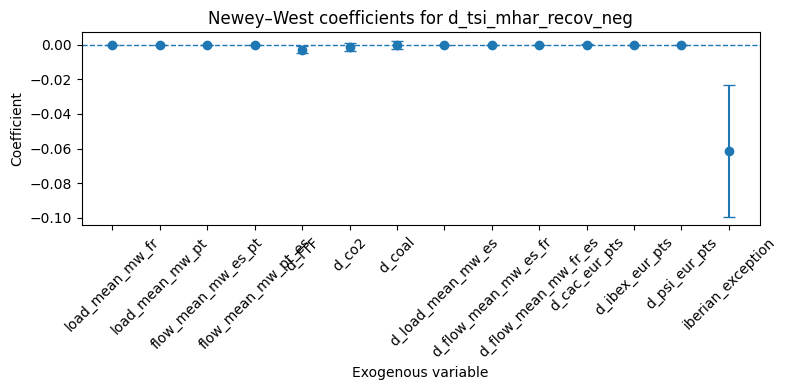

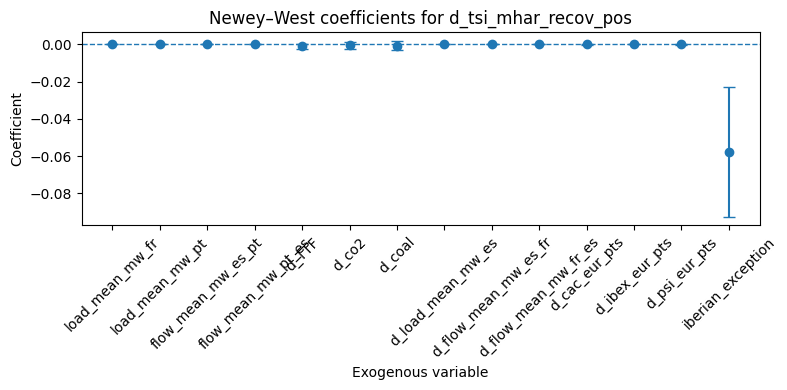

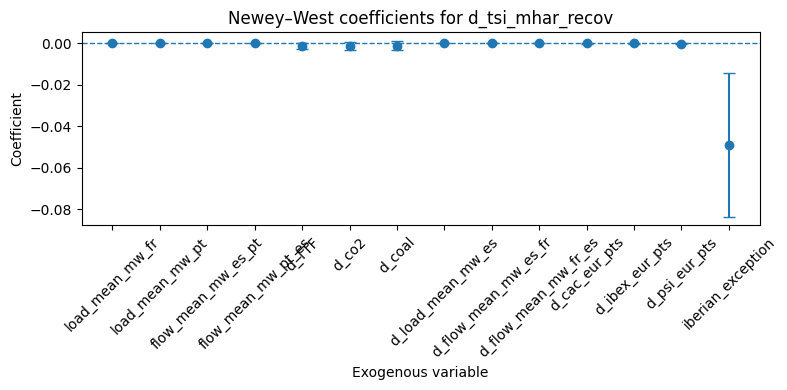

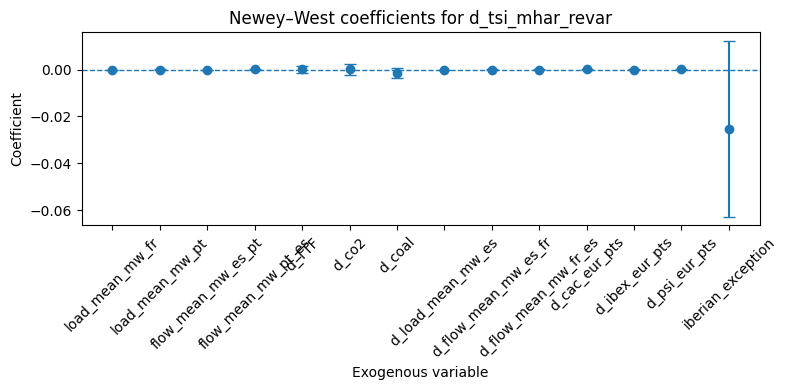

In [7]:

# Run Newey–West regressions
nw_lags = 10 
results = run_nw_regressions(
    data=data,
    endog_names=endog_names,
    exog_names=exog_names,
    maxlags=nw_lags,
)

# Build coefficient table
coef_df = build_coef_table(results, exog_names)
display(coef_df.head(20))

# Save coefficient table
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_coef_path = OUT_DIR / "nw_regression_results.csv"
coef_df.to_csv(out_coef_path, index=False)
print(f"Saved coefficient table to: {out_coef_path}")

# Example plots for each endogenous series
for y_name in endog_names:
    plot_coefficients_for_endog(coef_df, y_name)
